## Epileptic Seizure Recognition Data Set, classification

### Data pre-processing 

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score

In [2]:
# Read data
df = pd.read_csv("data.csv")
X = df.iloc[:,1:-1]
y = np.array(df["y"])
y = (y == 1)*1
n,d = X.shape

### Exploratory data analysis

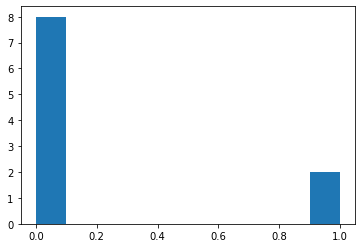

In [35]:
# Skewed classes
plt.hist(y, density=True)
plt.show()

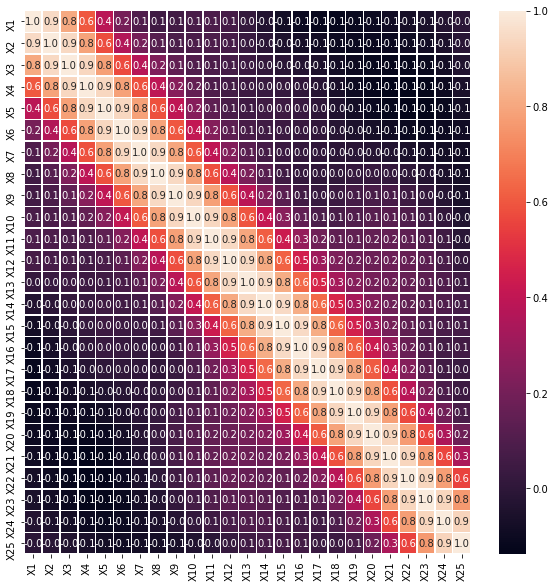

In [36]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X.iloc[:5000,:25].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

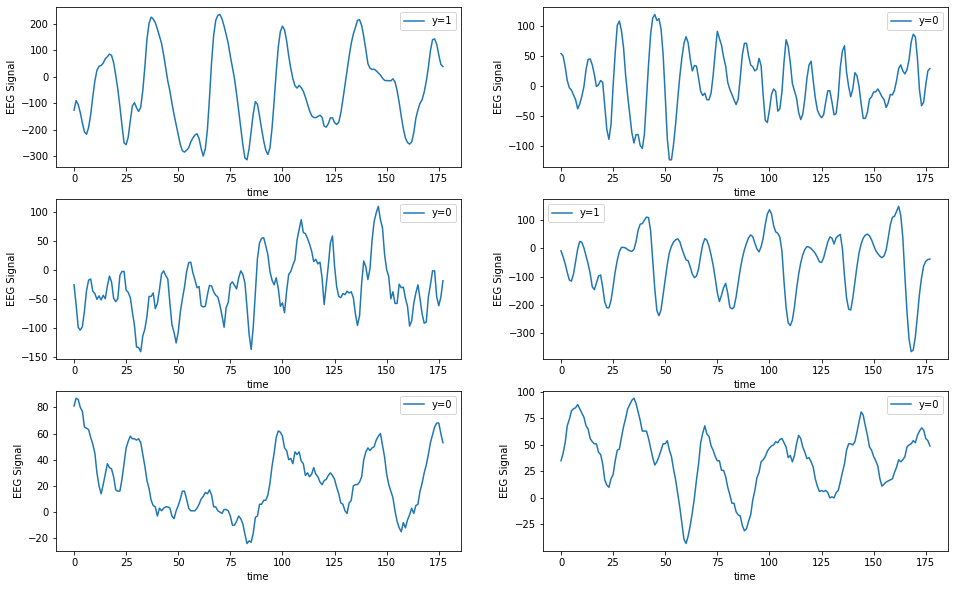

In [37]:
# Sample viz
nsample = 6
idx = np.random.randint(0,n,nsample)
fig, axs = plt.subplots(int(nsample/2), 2, figsize=(16,10))


for i in range(int(nsample/2)):
    for j in range(2):
        
        sample = np.array(X.iloc[idx[2*i+j],:])
        axs[i,j].plot(sample, label = "y={}".format(y[idx[2*i+j]]))
        axs[i,j].set_xlabel("time")
        axs[i,j].set_ylabel("EEG Signal")
        axs[i,j].legend()

        
#plt.savefig("ex_eeg")
plt.show()

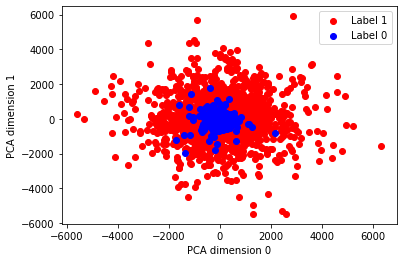

In [38]:
# Data viz with PCA 
from sklearn.decomposition import PCA
pca = PCA(2)
Xnew = pca.fit_transform(X)
idx_one = (y==1)

plt.scatter(Xnew[idx_one,0], Xnew[idx_one,1], c='red', label = "Label 1")
plt.scatter(Xnew[~idx_one,0], Xnew[~idx_one,1], c='blue', label = "Label 0")
plt.legend()
plt.xlabel("PCA dimension 0")
plt.ylabel("PCA dimension 1")

#plt.savefig("pca_red")
plt.show()

### State of the art

In [39]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [40]:
# SVM
svm = SVC(gamma = "auto")
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)
acc = (ypred == y_test).mean()
f1 = f1_score(y_test, ypred)
acc_bal = balanced_accuracy_score(y_test, ypred)
aps = average_precision_score(y_test, ypred)


print("Accuracy = {}".format(acc))
print("Accuracy (balanced) = {}".format(acc_bal))
print("F1-score = {}".format(f1))
print("Average Precision Score = {}".format(aps))

Accuracy = 0.9700869565217392
Accuracy (balanced) = 0.942951489948466
F1-score = 0.9266211604095563
Average Precision Score = 0.88154114409751


In [41]:
# Hyperparameters selection for gradient boosting
clf = xgb.XGBClassifier()

parameters = {
    'n_estimators': [250,300],
    'max_depth': [4,5,6] 
}


grid_search = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = -1,
    cv = 3,
    verbose=True,
    refit=True
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
best_xgb

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.0min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Accuracy = 0.9728695652173913
Accuracy (balanced) = 0.9465285444366385
F1-score = 0.9333333333333335
Average Precision Score = 0.8931046610674018


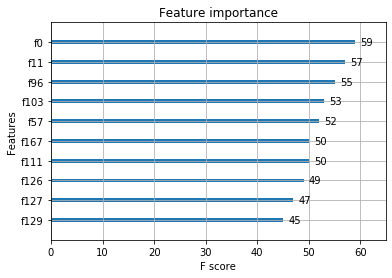

In [42]:
# Gradient boosting
pred = best_xgb.predict(X_test)
acc = (pred == y_test).mean()
f1 = f1_score(y_test, pred)
acc_bal = balanced_accuracy_score(y_test, pred)
aps = average_precision_score(y_test, pred)


print("Accuracy = {}".format(acc))
print("Accuracy (balanced) = {}".format(acc_bal))
print("F1-score = {}".format(f1))
print("Average Precision Score = {}".format(aps))

plot_importance(best_xgb, max_num_features=10)
#plt.savefig("xgb_importance")
plt.show()

In [43]:
# Deision trees
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)


#dot_data = tree.export_graphviz(clf_dt, out_file=None, max_depth=3)
#graph = graphviz.Source(dot_data)
#graph.render("arbre_dt")


pred = clf_dt.predict(X_test)
acc = (pred == y_test).mean()
f1 = f1_score(y_test, pred)
acc_bal = balanced_accuracy_score(y_test, pred)

print("Accuracy = {}".format(acc))
print("Accuracy (balanced) = {}".format(acc_bal))
print("F1-score = {}".format(f1))
print("Average Precision Score = {}".format(aps))

Accuracy = 0.9342608695652174
Accuracy (balanced) = 0.8882040473769721
F1-score = 0.8383233532934132
Average Precision Score = 0.8931046610674018


In [44]:
## Learn models
model1_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

model2_dt = DecisionTreeClassifier()
model3_svm = SVC(gamma = "auto", probability=True)

model1_xgb.fit(X_train, y_train)
model2_dt.fit(X_train, y_train)
model3_svm.fit(X_train, y_train)


# Predict probabilities for each models
xgb_probs = model1_xgb.predict_proba(X_test)
dt_probs = model2_dt.predict_proba(X_test)
svm_probs = model3_svm.predict_proba(X_test)


ns_probs = [0 for _ in range(y_test.shape[0])]
xgb_probs = xgb_probs[:, 1]
dt_probs = dt_probs[:, 1]
svm_probs = svm_probs[:, 1]

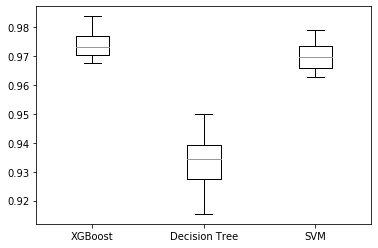

In [45]:
# Models comparaison with cross validation
xgb_cv = cross_val_score(model1_xgb, X_train, y_train, cv=10)
dt_cv = cross_val_score(model2_dt, X_train, y_train, cv=10)
svm_cv = cross_val_score(model3_svm, X_train, y_train, cv=10)

res = [xgb_cv, dt_cv, svm_cv]
names = ["XGBoost", "Decision Tree", "SVM"]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(res)
ax.set_xticklabels(names)
plt.show()
#plt.savefig("accuracy_cv")

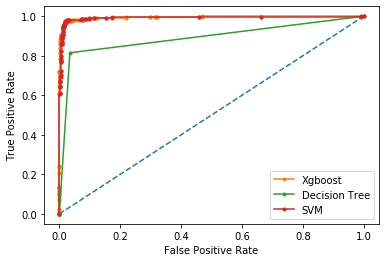

In [46]:
# Models comparaison with ROC curve

# Scores 
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
svm_auc = roc_auc_score(y_test, svm_probs)


# ROC curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)


# Vizualisation 
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='Xgboost')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
#plt.savefig("roc_curve")

### Deep learning with Pytorch

##### Initialisation

In [47]:
############ With up-sampling ############


X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2)

ntrain, _ = X_train.shape
idx_one = (y_train == 1)
nb_one = idx_one.sum()
nb_zeros = ntrain - nb_one
idx_one = np.arange(0,ntrain)[idx_one]
idx_to_sample = int(nb_zeros-nb_one)
idx_sample = np.random.choice(idx_one, idx_to_sample)
to_add_x = X_train[idx_sample,:]
to_add_y = y_train[idx_sample]

X_train = np.concatenate((to_add_x, X_train), axis=0)
y_train = np.concatenate((to_add_y, y_train), axis=0)


scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

X_train = torch.from_numpy(X_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
y_train = torch.from_numpy(y_train).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)
ntest = y_test.shape[0]

In [3]:
############ Without up-sampling ############

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

X_train = torch.from_numpy(X_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
y_train = torch.from_numpy(y_train).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)
ntest = y_test.shape[0]

In [4]:
# Dataset and dataloader
batch_size = 256

class EEG_dataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        return self.X[index,:], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]
    
dataset = EEG_dataset(X_train, y_train)
dataset_test = EEG_dataset(X_test, y_test)

dataloader = DataLoader(dataset, shuffle=True, batch_size = batch_size)
dataloader_test = DataLoader(dataset_test, shuffle=False, batch_size = ntest)

##### Models

In [24]:
# GRU/LSTM

class Model_rnn(nn.Module):
    
    def __init__(self, seq_len, hidden_size):
        super(Model_rnn, self).__init__()
        self.input_size = 1
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size)
        self.gru = nn.GRU(input_size=1, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size,1) # prediction 0/1

    def forward(self, x):
        #out, (ht, ct) = self.lstm(x)
        _, ht = self.gru(x)
        probs = torch.sigmoid(self.lin(ht))
        return probs.squeeze()

In [7]:
# MLP with 2 layers

class Model_eeg2(nn.Module):
    
    def __init__(self, seq_len, hidden_size):
        super(Model_eeg2, self).__init__()
        self.input_size = 1
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.lin1 = nn.Linear(seq_len, hidden_size)
        self.lin2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hidden = torch.relu(self.lin1(x))
        probs = torch.sigmoid(self.lin2(hidden))
        return probs.squeeze()

In [8]:
# General MLP

class Model_eeg3(nn.Module):
    
    def __init__(self, seq_len, hsize_list):
        super(Model_eeg3, self).__init__()
        self.input_size = 1
        self.seq_len = seq_len
        self.hsize_list = hsize_list
        self.module = nn.ModuleList([])
        self.module.append(nn.Linear(seq_len, hsize_list[0]))
        for i in range(len(hsize_list)-1):
            self.module.append(nn.Linear(hsize_list[i], hsize_list[i+1]))
        self.module.append(nn.Linear(hsize_list[-1], 1))

    def forward(self, x):
        for i in range(len(self.hsize_list)):
            x = torch.relu(self.module[i](x))
        x = torch.sigmoid(self.module[-1](x))
        return x.squeeze()

In [9]:
# Convolution neural net

class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    

class ConvNet(nn.Module):
    def __init__(self, out_channels, inSize = 178, kernel_size=3, stride=1, drop_rate=0):
        super(ConvNet, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.drop_rate = drop_rate
        
        
        self.main = nn.Sequential(
            nn.Conv1d(1, out_channels, kernel_size, stride),
            nn.MaxPool1d(kernel_size, stride),
            nn.Conv1d(out_channels, out_channels*2, kernel_size, stride+1),
            nn.MaxPool1d(kernel_size, stride+1),
            nn.Conv1d(out_channels*2, out_channels*4, kernel_size, stride+1),
            nn.MaxPool1d(kernel_size, stride+1),
            nn.AdaptiveMaxPool1d(1), # to have result of size N x out_channels*4 x 1
            Flatten()
            
        )

        
        size=out_channels*4
        self.lin = nn.Linear(size,1)
        self.drop = nn.Dropout(self.drop_rate)
        
        
        
    def forward(self, x):
        conv_flatt = self.main(x)
        lin = self.lin(conv_flatt)
        #lin = self.drop(lin)
        prob = torch.sigmoid(lin)
        return prob.squeeze()
    
    
    def predict(self, xtest):
        xtest = xtest.reshape(xtest.shape[0],1,178)
        ypred = self.forward(xtest)
        ypred = (ypred >= 0.5).to(torch.float)
        return ypred

##### Apprentissage

In [46]:
# Hyperparameters
lr = 0.005
nepochs = 150
seq_len = 178
hsize = 30
dr = 0

In [47]:
# Learn for convolution model

model = ConvNet(hsize, drop_rate=dr)
optim = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.BCELoss(reduction = "mean")
accuracys = []
f1_scores = []
acc_bal_scores = []
aps_scores = []

for epoch in range(nepochs):
    # 1) Train
    model.train()
    for x,y in dataloader:
        x = x.reshape(x.shape[0],1,178) 
        ypred = model(x)
        l = loss(ypred,y)
        optim.zero_grad()
        l.backward()
        optim.step()
        
    # 2) Test 
    model.eval()
    acc = 0.
    for xtest, ytest in dataloader_test:
        xtest = xtest.reshape(xtest.shape[0],1,178)
        ypred = model(xtest)
        ypred = (ypred >= 0.5).to(torch.float)
        acc += (ypred == ytest).sum().item()
        f1 = f1_score(ytest, ypred)
        aps = average_precision_score(ytest, ypred)
        acc_bal = balanced_accuracy_score(ytest, ypred)

    acc /= len(dataset_test)
    accuracys.append(acc)
    f1_scores.append(f1)
    aps_scores.append(aps)
    acc_bal_scores.append(acc_bal)
    
    # Early stopping
    if (acc >= 0.988): break
    
    if (epoch % 10 == 0): print("Epoch no {}, test accuracy = {}, f1 score = {}, balanced accuracy = {}, average precision = {}".format(epoch, round(acc,3), round(f1,3), round(acc_bal,3), round(aps,3)))

Epoch no 0, test accuracy = 0.948, f1 score = 0.865, balanced accuracy = 0.894, average precision = 0.794
Epoch no 10, test accuracy = 0.974, f1 score = 0.935, balanced accuracy = 0.947, average precision = 0.895
Epoch no 20, test accuracy = 0.98, f1 score = 0.95, balanced accuracy = 0.961, average precision = 0.917
Epoch no 30, test accuracy = 0.982, f1 score = 0.954, balanced accuracy = 0.96, average precision = 0.928
Epoch no 40, test accuracy = 0.983, f1 score = 0.959, balanced accuracy = 0.969, average precision = 0.932


Last F1-score = 0.9714285714285714
Last Accuracy = 0.9882608695652174
Last Accuracy (balanced) = 0.9794016290726817
Last Average Precision Score = 0.9511165556423737


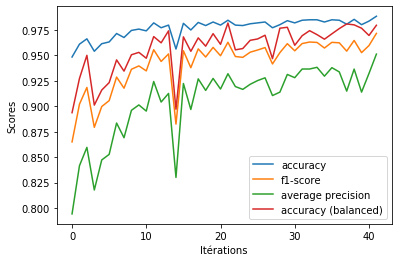

In [49]:
print("Last F1-score = {}".format(f1_scores[-1]))
print("Last Accuracy = {}".format(accuracys[-1]))
print("Last Accuracy (balanced) = {}".format(acc_bal_scores[-1]))
print("Last Average Precision Score = {}".format(aps_scores[-1]))

plt.plot(list(range(len(accuracys))), accuracys, label = 'accuracy')
plt.plot(list(range(len(f1_scores))), f1_scores, label = 'f1-score')
plt.plot(list(range(len(aps_scores))), aps_scores, label = 'average precision')
plt.plot(list(range(len(acc_bal_scores))), acc_bal_scores, label = 'accuracy (balanced)')

plt.xlabel("Itérations")
plt.ylabel("Scores")
plt.legend()
plt.savefig("convnet")
#plt.show()

In [45]:
# Learn RNN

lr = 0.0001
nepochs, hsize = 10, 15

model = Model_rnn(seq_len, hsize)
optim = torch.optim.RMSprop(model.parameters(), lr=lr)
loss = nn.BCELoss(reduction = "mean")


for epoch in range(nepochs):
    # 1) Train
    model.train()
    for x,y in dataloader:
        bsize, seqsize = x.shape
        x = x.reshape(seqsize, bsize, 1)
        ypred = model(x)
        l = loss(ypred,y)
        optim.zero_grad()
        l.backward()
        optim.step()
        
    # 2) Test 
    model.eval()
    acc = 0.
    for xtest, ytest in dataloader_test:
        bsize, seqsize = xtest.shape
        xtest = xtest.reshape(seqsize, bsize, 1)
        ypred = model(xtest)
        ypred = (ypred >= 0.5).to(torch.float)
        acc += (ypred == ytest).sum().item()
        f1 = f1_score(ytest, ypred)
        aps = average_precision_score(ytest, ypred)
        acc_bal = balanced_accuracy_score(ytest, ypred)

    acc /= len(dataset_test) 
    print("Epoch no {}, test accuracy = {}, f1 score = {}, balanced accuracy = {}, average precision = {}".format(epoch, round(acc,3), round(f1,3), round(acc_bal,3), round(aps,3)))

Epoch no 0, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 1, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 2, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 3, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 4, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 5, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 6, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 7, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 8, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, average precision = 0.207
Epoch no 9, test accuracy = 0.793, f1 score = 0.0, balanced accuracy = 0.5, averag